In [186]:
import math
import scipy.stats as stats
import pandas as pd

In [187]:
class Option:
        
    def __init__(self, S0, K, T, r, vol, notional=1000):
        self.S0 = S0
        self.K  = K
        self.T  = T
        self.r  = r
        self.vol= vol
        self.notional = notional
        self.d1 = (
            (math.log(self.S0/self.K) + (self.r + 0.5*self.vol*self.vol)*self.T) / (self.vol * math.sqrt(self.T))
        )
        self.N1 = stats.norm.cdf(self.d1)
        self.d2 = self.d1 - self.vol*math.sqrt(self.T)
        self.N2 = stats.norm.cdf(self.d2)
        self.C  = self.S0*self.N1 - self.K*math.exp(-self.r*self.T)*self.N2 
        self.premium = self.C * self.notional
        
    def get_delta(self, S, t):
        d1 = (math.log(S/self.K) + (self.r + 0.5*self.vol**2)*t) / (self.vol*math.sqrt(t))
        delta = stats.norm.cdf(d1)
        return delta
    
    def get_Si(self, S, dt):
        Si = S * math.exp(
            (self.r - 0.5*self.vol**2)*dt + self.vol*math.sqrt(dt) * stats.norm.rvs()
        )
        return Si
        

### Create Instance

In [188]:
opt = Option(S0=100, K=120, T=1, r=0.05, vol=0.2)

In [196]:
class Simulation:
    
    def __init__(self, option_object, num_rebalances, debug=False):
        self.option = option_object
        self.n = num_rebalances
        self.debug = debug
        
    def simulate(self):
        Si = self.option.S0
        remaining_term = self.option.T
        current_hedge_units = 0
        pv = 0
        
        for i in range(self.n+1):
            
            dt = 1/self.n

            if i == self.n:
                delta = 1 if Si > self.option.K else 0
            else:    
                delta = self.option.get_delta(Si, remaining_term)

            hedge_units = round(self.option.notional * delta, 0)
            hedge_cash  = round((current_hedge_units - hedge_units) * Si, 2)

            if i == self.n and delta == 1:
                hedge_cash += self.option.notional * self.option.K

            pvcf = round(hedge_cash * math.exp(-self.option.r * dt * i), 2)
            
            if self.debug:
                print("%3d %6.2f %4d %10.2f %10.2f" % (
                    i, Si, hedge_units, hedge_cash, pvcf
                ))

            pv += round(hedge_cash * math.exp(-self.option.r * dt * i), 2)

            remaining_term -= dt
            Si = round(self.option.get_Si(Si, dt), 2)
            current_hedge_units = hedge_units

        return round(-pv, 2)
        

### Example Run

In [197]:
sim = Simulation(opt, 12, debug=True)
result = sim.simulate()
error = result - opt.premium
perc_error = error / opt.premium * 100
print("\nPV %34.2f" % result)
print("Closed-form result %18.2f" % opt.premium)
print("Difference %26.2f" % error)
print("Percent error %22.1f%s" % (perc_error, "%"))

  0 100.00  287  -28700.00  -28700.00
  1  97.01  219    6596.68    6569.25
  2  91.62  123    8795.52    8722.53
  3  94.54  141   -1701.72   -1680.58
  4  93.40  106    3269.00    3214.97
  5  98.90  159   -5241.70   -5133.63
  6 102.07  185   -2653.82   -2588.30
  7 107.32  261   -8156.32   -7921.86
  8 107.34  223    4078.92    3945.20
  9 103.29   93   13427.70   12933.49
 10 102.27   35    5931.66    5689.59
 11  98.72    1    3356.48    3206.11
 12 100.27    0     100.27      95.38

PV                            1647.85
Closed-form result            3247.48
Difference                   -1599.63
Percent error                  -49.3%


In [198]:
def Simulate(n=12, m=1000):
    sim = Simulation(opt, n)
    r = []
    for i in range(m):
        result = sim.simulate()
        error = result - opt.premium
        perc_error = error / opt.premium * 100
        r.append(perc_error)
    return r

### Monthly Rebalancing

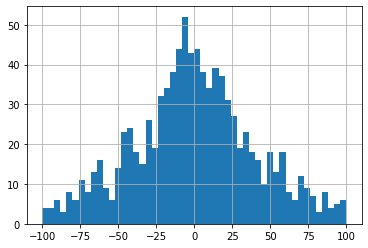

In [202]:
df = pd.DataFrame(data=Simulate(12, 1000), columns=['result'])
plt = df['result'].hist(bins=50, range = [-100, 100])

### Weekly Rebalancing

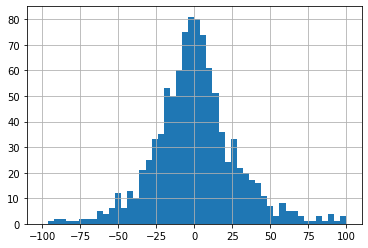

In [200]:
df = pd.DataFrame(data=Simulate(52, 1000), columns=['result'])
plt = df['result'].hist(bins=50, range = [-100, 100])

### Daily Rebalancing

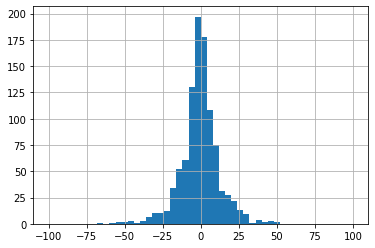

In [201]:
df = pd.DataFrame(data=Simulate(252, 1000), columns=['result'])
plt = df['result'].hist(bins=50, range = [-100, 100])